# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Only the main steps and key parameters are introduced in this notebook. Refer to detailed [Usage](https://github.com/Teichlab/celltypist#usage) if you want to learn more.

## Install CellTypist

In [3]:
import scanpy as sc
import pandas as pd

In [2]:
import celltypist
from celltypist import models

## Download a scRNA-seq dataset of 2,000 immune cells

In [5]:
import os
os.listdir()

['.Rhistory',
 'eda.Rmd',
 '.DS_Store',
 'annotation.ipynb',
 'Cortex.Rproj',
 'img',
 '.gitignore',
 '0417_annotation.Rmd',
 'expression',
 '.RDataTmp',
 '.git',
 'data',
 'celltypist_tutorial.ipynb',
 '.Rproj.user',
 'expression.zip',
 '0413_batch_correction.Rmd']

In [ ]:
expr = pd.read_csv('expression/preg1_cortex_counts.csv', index_col=0)
expr = expr.transpose()
adata = sc.AnnData(expr)
adata

AnnData object with n_obs × n_vars = 19718 × 5009

In [13]:
import scipy.sparse as sp

# Convert adata.X to sparse CSR matrix
adata.X = sp.csr_matrix(adata.X)

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

The expression matrix (`adata_2000.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [17]:
adata.X.expm1().sum(axis = 1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [18]:
adata.obs

""
aaabbcbo-1
aaagakna-1
aaagfglo-1
aaahagbk-1
aaaikmnd-1
...
oikdmpjc-1
oikmogep-1
oikneoaa-1
oilaellf-1


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [19]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /Users/damarisdeng/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallenge_

All models are stored in `models.models_path`.

In [20]:
models.models_path

'/Users/damarisdeng/.celltypist/data/models'

Get an overview of the models and what they represent.

In [21]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Human_Vascular.pkl,vascular populations combined from multiple ad...
9,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...


Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

In [22]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Mouse_Whole_Brain.pkl')

Show the model meta information.

In [23]:
model

CellTypist model with 334 cell types and 5596 features
    date: 2024-04-30 17:19:37.721313
    details: cell types from the whole adult mouse brain
    source: https://doi.org/10.1038/s41586-023-06812-z
    version: v1
    cell types: 001 CLA-EPd-CTX Car3 Glut, 002 IT EP-CLA Glut, ..., 338 Lymphoid NN
    features: Xkr4, Rgs20, ..., mt-Cytb

In [24]:
model.cell_types

array(['001 CLA-EPd-CTX Car3 Glut', '002 IT EP-CLA Glut',
       '003 L5/6 IT TPE-ENT Glut', '004 L6 IT CTX Glut',
       '005 L5 IT CTX Glut', '006 L4/5 IT CTX Glut',
       '007 L2/3 IT CTX Glut', '008 L2/3 IT ENT Glut',
       '009 L2/3 IT PIR-ENTl Glut', '010 IT AON-TT-DP Glut',
       '011 L2 IT ENT-po Glut', '012 MEA Slc17a7 Glut',
       '013 COAp Grxcr2 Glut', '014 LA-BLA-BMA-PA Glut',
       '015 ENTmv-PA-COAp Glut', '016 CA1-ProS Glut', '017 CA3 Glut',
       '018 L2 IT PPP-APr Glut', '019 L2/3 IT PPP Glut',
       '020 L2/3 IT RSP Glut', '021 L4 RSP-ACA Glut',
       '022 L5 ET CTX Glut', '023 SUB-ProS Glut', '024 L5 PPP Glut',
       '025 CA2-FC-IG Glut', '026 NLOT Rho Glut', '027 L6b EPd Glut',
       '028 L6b/CT ENT Glut', '029 L6b CTX Glut', '030 L6 CT CTX Glut',
       '031 CT SUB Glut', '032 L5 NP CTX Glut', '033 NP SUB Glut',
       '034 NP PPP Glut', '035 OB Eomes Ms4a15 Glut', '036 HPF CR Glut',
       '037 DG Glut', '038 DG-PIR Ex IMN', '039 OB Meis2 Thsd7b Gaba',


Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [25]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_2000, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata, model = 'Mouse_Whole_Brain.pkl', majority_voting = True)

🔬 Input data has 19718 cells and 5009 genes
🔗 Matching reference genes in the model
🧬 1851 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [26]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
aaabbcbo-1,202 PRT Tcf7l2 Gaba,68,326 OPC NN
aaagakna-1,006 L4/5 IT CTX Glut,58,006 L4/5 IT CTX Glut
aaagfglo-1,135 STN-PSTN Pitx2 Glut,106,319 Astro-TE NN
aaahagbk-1,155 PRC-PAG Pax6 Glut,7,030 L6 CT CTX Glut
aaaikmnd-1,046 Vip Gaba,57,333 Endo NN
...,...,...,...
oikdmpjc-1,331 Peri NN,44,331 Peri NN
oikmogep-1,331 Peri NN,44,331 Peri NN
oikneoaa-1,318 Astro-NT NN,9,167 PRC-PAG Tcf7l2 Irx2 Glut
oilaellf-1,327 Oligo NN,15,327 Oligo NN


Transform the prediction result into an `AnnData`.

In [27]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata_pred = predictions.to_adata()

Compared to `adata_2000`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [28]:
adata_pred.obs

,predicted_labels,over_clustering,majority_voting,conf_score
aaabbcbo-1,202 PRT Tcf7l2 Gaba,68,326 OPC NN,0.753103
aaagakna-1,006 L4/5 IT CTX Glut,58,006 L4/5 IT CTX Glut,0.670723
aaagfglo-1,135 STN-PSTN Pitx2 Glut,106,319 Astro-TE NN,0.009142
aaahagbk-1,155 PRC-PAG Pax6 Glut,7,030 L6 CT CTX Glut,0.066681
aaaikmnd-1,046 Vip Gaba,57,333 Endo NN,0.232697
...,...,...,...,...
oikdmpjc-1,331 Peri NN,44,331 Peri NN,0.001318
oikmogep-1,331 Peri NN,44,331 Peri NN,0.977391
oikneoaa-1,318 Astro-NT NN,9,167 PRC-PAG Tcf7l2 Irx2 Glut,0.016467
oilaellf-1,327 Oligo NN,15,327 Oligo NN,0.163439


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [30]:
# If the UMAP or any cell embeddings are already available in the `AnnData`, skip this command.
sc.tl.umap(adata_pred)

In [32]:
adata_pred

AnnData object with n_obs × n_vars = 19718 × 5009
    obs: 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    uns: 'log1p', 'neighbors', 'over_clustering', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

Visualise the prediction results.

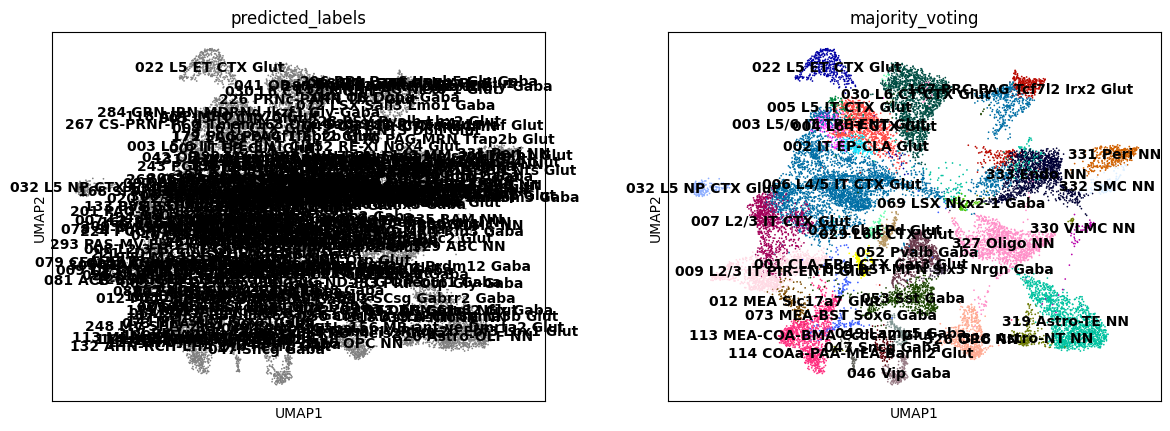

In [33]:
sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting'], legend_loc = 'on data')

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.dotplot.html), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

In [34]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

KeyError: "🛑 Did not find such column 'cell_type', please provide a valid metadata column"

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

## Assign cell type labels using a custom model
In this section, we show the procedure of generating a custom model and transferring labels from the model to the query data.

Use previously downloaded dataset of 2,000 immune cells as the training set.

In [ ]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

Download another scRNA-seq dataset of 400 immune cells as a query.

In [ ]:
adata_400 = sc.read('celltypist_demo_folder/demo_400_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_400_cells.h5ad')

  0%|          | 0.00/7.62M [00:00<?, ?B/s]

Derive a custom model by training the data using the [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) function.

In [ ]:
# The `cell_type` in `adata_2000.obs` will be used as cell type labels for training.
new_model = celltypist.train(adata_2000, labels = 'cell_type', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
✂️ 2749 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2607 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


Refer to the function [celltypist.train](https://celltypist.readthedocs.io/en/latest/celltypist.train.html) for what each parameter means, and to the [usage](https://github.com/Teichlab/celltypist#usage) for details of model training.

This custom model can be manipulated as with other CellTypist built-in models. First, save this model locally.

In [ ]:
# Save the model.
new_model.write('celltypist_demo_folder/model_from_immune2000.pkl')

You can load this model by `models.Model.load`.

In [ ]:
new_model = models.Model.load('celltypist_demo_folder/model_from_immune2000.pkl')

Next, we use this model to predict the query dataset of 400 immune cells.

In [ ]:
# Not run; predict the identity of each input cell with the new model.
#predictions = celltypist.annotate(adata_400, model = new_model, majority_voting = True)
# Alternatively, just specify the model path (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata_400, model = 'celltypist_demo_folder/model_from_immune2000.pkl', majority_voting = True)

🔬 Input data has 400 cells and 18950 genes
🔗 Matching reference genes in the model
🧬 2607 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 5
🗳️ Majority voting the predictions
✅ Majority voting done!


In [ ]:
adata = predictions.to_adata()

In [ ]:
sc.tl.umap(adata)

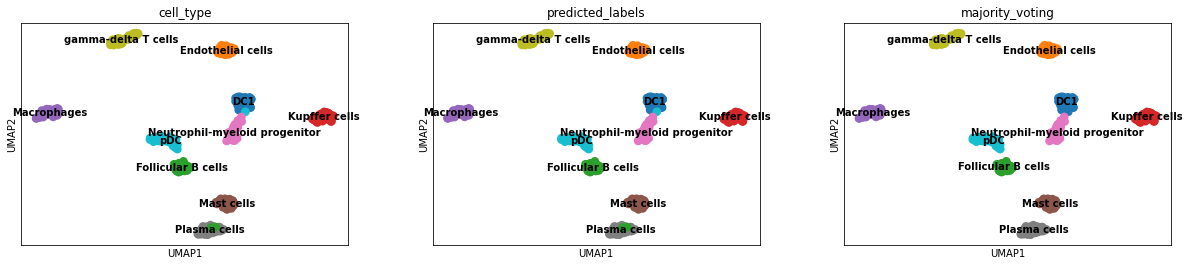

In [ ]:
sc.pl.umap(adata, color = ['cell_type', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

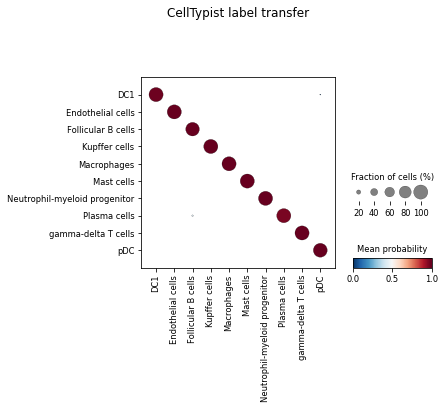

In [ ]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Note these genes are only dependent on the model, say, the training dataset.

In [ ]:
# Any model can be inspected.
# Here we load the previously saved model trained from 2,000 immune cells.
model = models.Model.load(model = 'celltypist_demo_folder/model_from_immune2000.pkl')

In [ ]:
model.cell_types

array(['DC1', 'Endothelial cells', 'Follicular B cells', 'Kupffer cells',
       'Macrophages', 'Mast cells', 'Neutrophil-myeloid progenitor',
       'Plasma cells', 'gamma-delta T cells', 'pDC'], dtype=object)

Extract the top three driving genes of `Mast cells` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.models.Model.html#celltypist.models.Model.extract_top_markers) method.

In [ ]:
top_3_genes = model.extract_top_markers("Mast cells", 3)
top_3_genes

array(['TPSB2', 'TPSAB1', 'CPA3'], dtype=object)

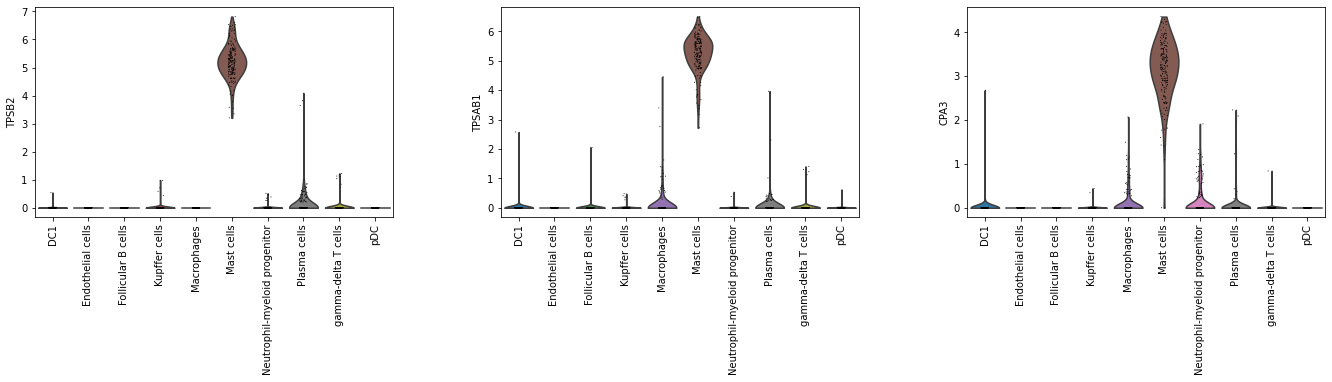

In [ ]:
# Check expression of the three genes in the training set.
sc.pl.violin(adata_2000, top_3_genes, groupby = 'cell_type', rotation = 90)

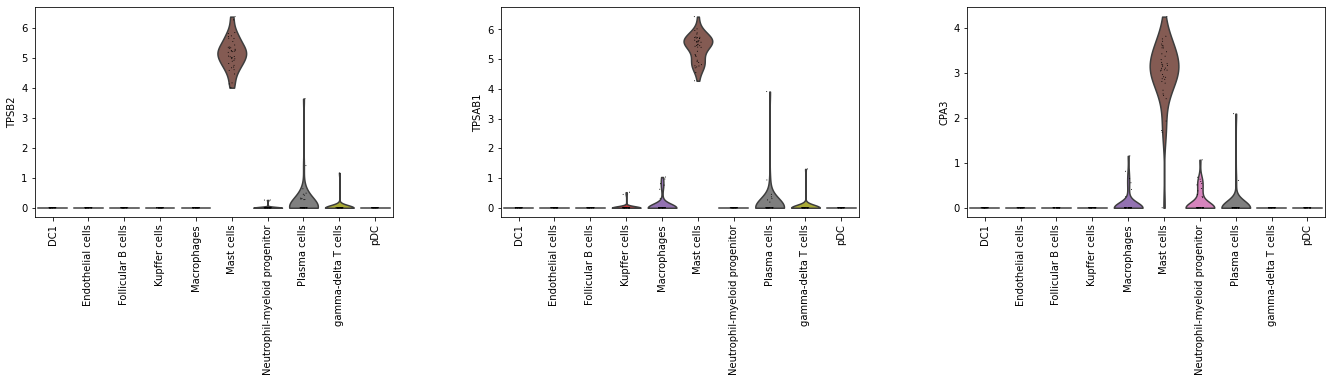

In [ ]:
# Check expression of the three genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
sc.pl.violin(adata_400, top_3_genes, groupby = 'majority_voting', rotation = 90)